# __Unstacking confocal images__

__Goal: preparing confocal images to a suitable format for classification models__ <br>

The images coming from confocal microscope are in tif format with four stacks: <br>
(4, x, x) OR (x, x, 4) <br>

_convert_tiff_channel_to_jpg_ <br>
This function convert one stack of a single tif image to jpg format. <br>

_process_folder_tiffs_ <br>
This function converts tif images of a given folder into jpg format just like _convert_tiff_channel_to_jpg_. 

In [1]:
# data wrangling
import numpy as np
# image processing
import tifffile
from PIL import Image
from pathlib import Path

Displaying the four stacks of one tif image

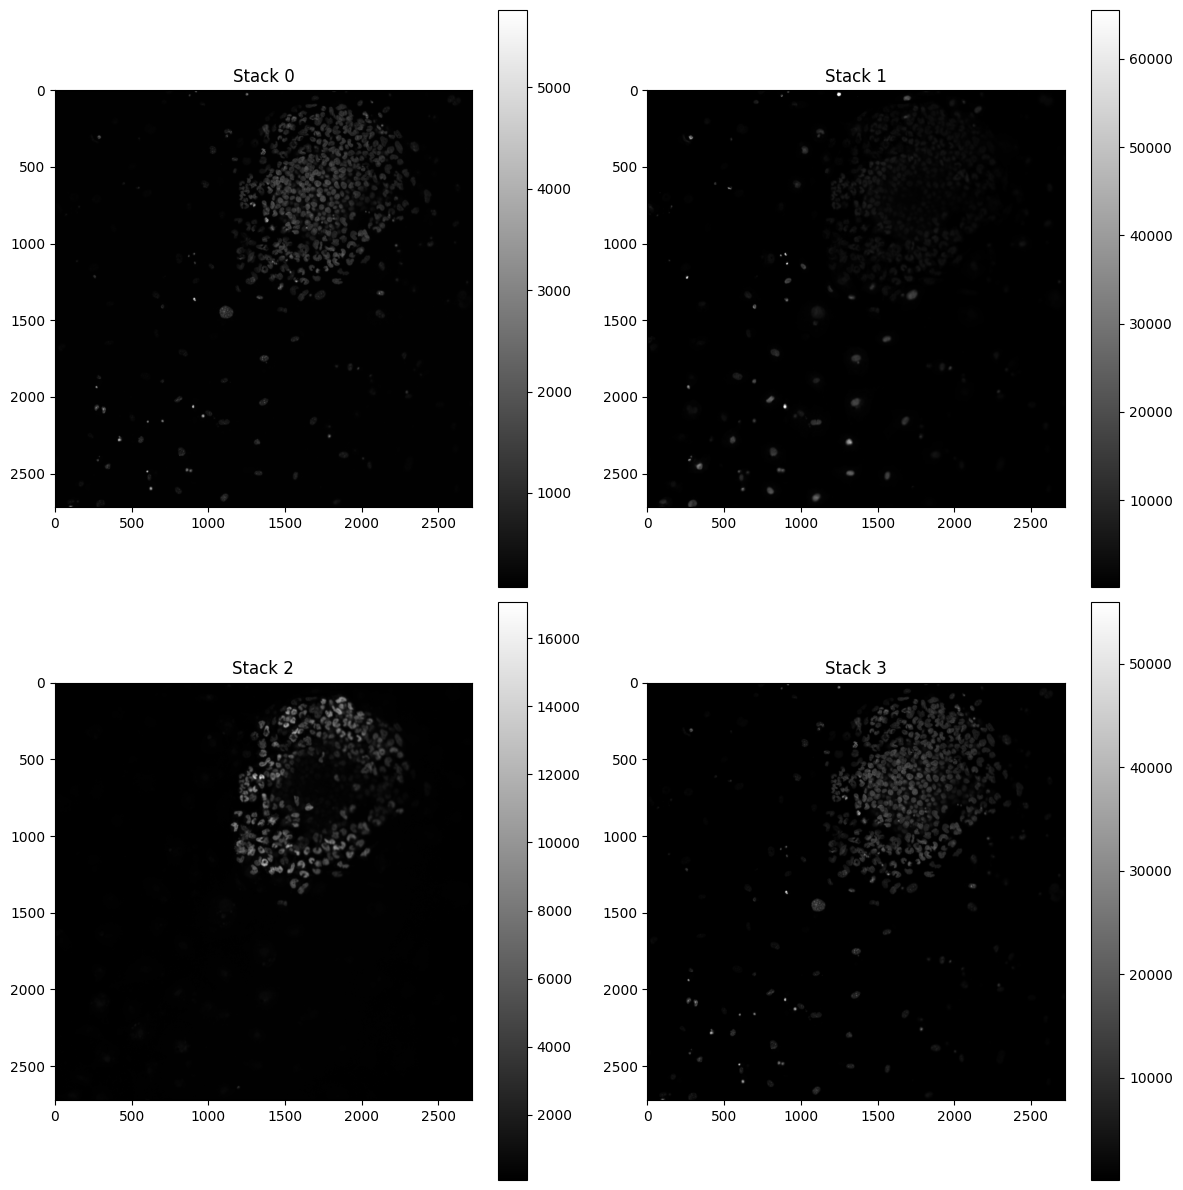


Stack 0 information:
Shape: (2720, 4)
Min value: 82
Max value: 15576
Mean value: 227.84

Stack 1 information:
Shape: (2720, 4)
Min value: 81
Max value: 9459
Mean value: 222.87

Stack 2 information:
Shape: (2720, 4)
Min value: 73
Max value: 7844
Mean value: 217.93

Stack 3 information:
Shape: (2720, 4)
Min value: 82
Max value: 7567
Mean value: 213.76


In [96]:
# Read the TIFF file
# Replace 'your_image.tif' with your actual file path
image = tifffile.imread('../data/train/B/E09_t7_NaiveCult_s40.tif')
image.shape

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()  # Flatten the axes array for easier iteration

# Plot each stack
for i in range(4):
    im = axes[i].imshow(image[:,:,i], cmap='gray')
    axes[i].set_title(f'Stack {i}')
    plt.colorbar(im, ax=axes[i])

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()

# Print information about each stack
for i in range(4):
    stack = image[i]
    print(f"\nStack {i} information:")
    print(f"Shape: {stack.shape}")
    print(f"Min value: {stack.min()}")
    print(f"Max value: {stack.max()}")
    print(f"Mean value: {stack.mean():.2f}")

_convert_tiff_channel_to_jpg_ for converting of single tif file

In [2]:
def convert_tiff_channel_to_jpg(tiff_path, channel_index=0, output_size=(24, 24), create_negative=True):
    """
    Convert a specific channel from a TIFF file to a JPG, with option to create negative.
    
    Parameters:
    -----------
    tiff_path : str or Path
        Path to the input TIFF file
    channel_index : int
        Index of the channel to process (default: 0)
    output_size : tuple
        Size of the output JPG (width, height) (default: (24, 24))
    create_negative : bool
        Whether to create a negative of the image (default: True)
    
    Returns:
    --------
    str
        Path to the saved JPG file
    """
    # Convert path to Path object
    tiff_path = Path(tiff_path)
    
    # Read the TIFF file
    image = tifffile.imread(str(tiff_path))
    
    # Get the specified channel (now using the last dimension)
    if image.shape[2] == 4:
        channel = image[:, :, channel_index]
    else:
        channel = image[channel_index]
    
    # Create negative if requested
    if create_negative:
        if channel.dtype == np.uint16:
            processed = 65535 - channel
            processed = (processed / 256).astype(np.uint8)
        elif channel.dtype == np.uint8:
            processed = 255 - channel
        else:
            processed = ((channel - channel.min()) / 
                        (channel.max() - channel.min()) * 255).astype(np.uint8)
            processed = 255 - processed
    else:
        # Just normalize to 8-bit if not creating negative
        if channel.dtype == np.uint16:
            processed = (channel / 256).astype(np.uint8)
        elif channel.dtype == np.uint8:
            processed = channel
        else:
            processed = ((channel - channel.min()) / 
                        (channel.max() - channel.min()) * 255).astype(np.uint8)
    
    # Convert to PIL Image and resize
    pil_image = Image.fromarray(processed)
    resized_image = pil_image.resize(output_size, Image.Resampling.LANCZOS)
    
    # Create output filename
    output_path = tiff_path.parent / f"{tiff_path.stem}_channel{channel_index}.jpg"
    
    # Save the image
    resized_image.save(output_path, quality=95)
    
    return str(output_path)

In [123]:
# Example usage
if __name__ == "__main__":
    # Example usage with a single file
    tiff_file = "../data/train/A/B03_t0_PGL_s01.tif"
    
    # Convert channel 0 to negative JPG
    output_path = convert_tiff_channel_to_jpg(
        tiff_path=tiff_file,
        channel_index=0,      # Choose which channel to convert (0-3)
        output_size=(240, 240), # Output image size
        create_negative=True  # Create negative
    )
    
    print(f"Converted image saved to: {output_path}")

Converted image saved to: ..\data\train\A\B03_t0_PGL_s01_channel0.jpg


_process_folder_tiffs_ for converting a whole folder with tif images_ <br>

- channel_index: this argument indicates the stack to be exported in jpg format
- output_size: the size of the jpg


In [3]:
# Now, let's create a function to process all TIFF files in a folder
def process_folder_tiffs(folder_path, channel_index=0, output_size=(224, 224), create_negative=True):
    """
    Process all TIFF files in a folder and convert specified channels to JPG.
    
    Parameters:
    -----------
    folder_path : str or Path
        Path to the folder containing TIFF files
    channel_index : int
        Index of the channel to process (default: 0)
    output_size : tuple
        Size of output JPG (width, height) (default: (24, 24))
    create_negative : bool
        Whether to create negative of the image (default: True)
    
    Returns:
    --------
    dict
        Summary of processing results
    """
    folder_path = Path(folder_path)
    
    # Initialize results dictionary
    results = {
        'processed_files': [],
        'errors': [],
        'total_processed': 0
    }
    
    # Get all TIFF files in the folder
    tiff_files = list(folder_path.glob('*.tif')) + list(folder_path.glob('*.tiff'))
    total_files = len(tiff_files)
    
    # Process each TIFF file
    for i, tiff_file in enumerate(tiff_files, 1):
        try:
            # Process the file
            output_path = convert_tiff_channel_to_jpg(
                tiff_file,
                channel_index=channel_index,
                output_size=output_size,
                create_negative=create_negative
            )
            
            results['processed_files'].append(output_path)
            results['total_processed'] += 1
            
            # Print progress
            print(f"Processed {i}/{total_files}: {tiff_file.name}")
            
        except Exception as e:
            error_msg = f"Error processing {tiff_file.name}: {str(e)}"
            results['errors'].append(error_msg)
            print(f"Error: {error_msg}")
    
    return results

In [4]:
# Example usage
if __name__ == "__main__":
    # Replace with your folder path
    folder_path = "../data/test/tif/"
    
    # Process all TIFF files in the folder
    results = process_folder_tiffs(
        folder_path=folder_path,
        channel_index=3,       # Choose which channel to convert (0-3)
        output_size=(224, 224),  # Output image size
        create_negative=True   # Create negative images
    )
    
    # Print summary
    print("\nProcessing Summary:")
    print(f"Total files processed: {results['total_processed']}")
    print(f"Files with errors: {len(results['errors'])}")
    
    if results['errors']:
        print("\nErrors encountered:")
        for error in results['errors']:
            print(error)
    
    print("\nProcessing complete!")

Processed 1/10: B02_t0_PGL_s12.tif
Processed 2/10: B02_t0_PGL_s30.tif
Processed 3/10: C07_t7_PXGL_s41.tif
Processed 4/10: C07_t7_PXGL_s48.tif
Processed 5/10: D09_t7_t2iLGo_s02.tif
Processed 6/10: D09_t7_t2iLGo_s06.tif
Processed 7/10: E03_t0_NaiveCult_s01.tif
Processed 8/10: E03_t0_NaiveCult_s20.tif
Processed 9/10: F09_t7_IWP2_s10.tif
Processed 10/10: F09_t7_IWP2_s21.tif

Processing Summary:
Total files processed: 10
Files with errors: 0

Processing complete!
